In [1]:
from PIL import Image
from io import BytesIO
import base64
import requests

In [2]:
class ModelServices():
    def __init__(self, iServers_config = None):
        self.servers_config = iServers_config if iServers_config else {}
    
    def set_detect_objects_server(self, iModel_url):
        self.servers_config["detect_objects"] = iModel_url

    def set_sam_server(self, iModel_url):
        self.servers_config["sam"] = iModel_url
    
    def set_clip_server(self, iModel_url):
        self.servers_config["clip"] = iModel_url

    def set_open_pose_server(self, iModel_url):
        self.servers_config["open_pose"] = iModel_url

    def clip_image(self, iImage : Image, iTags):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue()).decode('utf-8')
        
        vJsonRequest = {
            "image": vImageBase64,
            "tags": iTags
        }
        vResponse = requests.post(
            self.servers_config["clip"] + "/genera/clip",
            json = vJsonRequest
        )

        return vResponse.json()["data"]

    def detect_objects(self, iImage : Image, iSearched_label = list(), iRoundBoxes = True):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue()).decode('utf-8')
        
        vJsonRequest = {
            "image": vImageBase64
        }
        vResponse = requests.post(
            self.servers_config["detect_objects"] + "/genera/object_detection",
            json = vJsonRequest
        )

        vResponse = vResponse.json()["data"]
        vFilteredResult = [x for x in vResponse if x["label_name"] in iSearched_label or iSearched_label is None or len(iSearched_label) == 0]
        for tResult in vFilteredResult:
            tResult["box"] = [(round(x) if iRoundBoxes else x) for x in tResult["box"]]
            # Bug that values close to 0 it's rounded to -1.
            #tResult["box"] = [(x if x >= 0 else 0) for x in tResult["box"]]
            
            vWidth = tResult["box"][2] - tResult["box"][0]
            vHeigth = tResult["box"][3] - tResult["box"][1]
            tResult["width"] = vWidth
            tResult["heith"] = vHeigth
            tResult["area"] = vWidth * vHeigth
            tResult["relative_area"] = (vWidth * vHeigth) / (iImage.size[0] * iImage.size[1])
        return vFilteredResult

    def generate_masks(self, iImage, iBoxes):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue())
        vImageBase64 = vImageBase64.decode('utf-8')
        vJsonRequest = {
            "image": vImageBase64,
            "boxes": iBoxes,
            "shape": iImage.size
        }

        vResponse = requests.post(
            self.servers_config["sam"] + "/genera/segments/box",
            json = vJsonRequest
        )
        vMasks = list()
        for tMask in vResponse.json()["masks"]:
            tMask = base64.b64decode(tMask)
            tMask = Image.open(BytesIO(tMask))
            vMasks.append(tMask)
        return vMasks

    def generate_open_pose(self, iImage):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue())
        vImageBase64 = vImageBase64.decode('utf-8')
        vJsonRequest = {
            "image": vImageBase64,
            "shape": iImage.size
        }

        vResponse = requests.post(
            self.servers_config["open_pose"] + "/genera/open_pose",
            json = vJsonRequest
        )
        vImage = vResponse.json()["image"]
        vImage = base64.b64decode(vImage)
        vImage = Image.open(BytesIO(vImage))
        return vImage

gAIServer = ModelServices()
gAIServer.set_clip_server("http://localhost:82")
gAIServer.set_detect_objects_server("http://localhost:88")
gAIServer.set_sam_server("http://localhost:80")
gAIServer.set_open_pose_server("http://localhost:81")

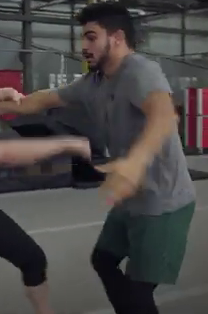

In [3]:
vImage = Image.open("../resources/cache/frame_1047/cropped_0.png").convert('RGB')
vImage

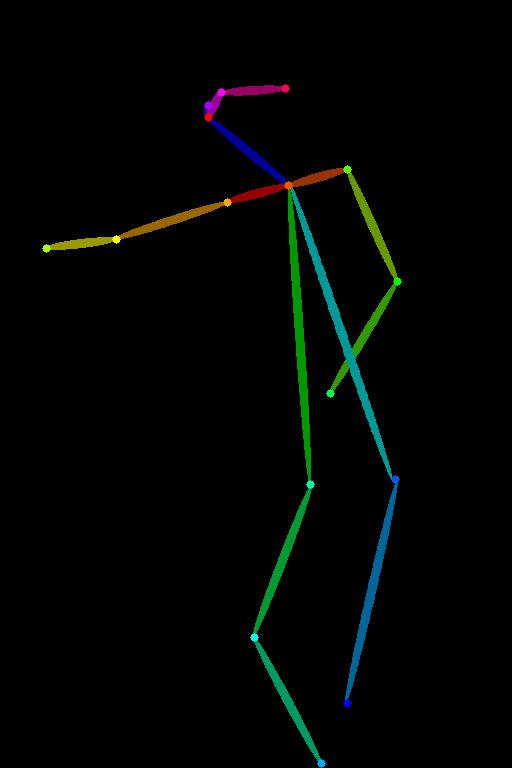

In [4]:
vPoseImage = gAIServer.generate_open_pose(vImage)
vPoseImage.save("../resources/cache/frame_1047/open_pose_0.png")
vPoseImage

In [35]:
import os
relevant_path = "../resources/cache/"
included_extensions = ['png']
directorys = [fn for fn in os.listdir(relevant_path)]
vIndex = 0
for tDirectory in directorys:
    vDirPath = relevant_path + tDirectory + "/"
    vFiles = [fn for fn in os.listdir(vDirPath) if "cropped_" in fn]
    if len(vFiles) > 0:
        for tFileName in vFiles:
            print(f"\rProcessing directori [{tDirectory}] -->", tFileName, ": processed", str(vIndex) + "/" + str(len(directorys)), end = "")
            vImage = Image.open(vDirPath + tFileName).convert('RGB')
            vPoseImage = gAIServer.generate_open_pose(vImage)
            vPoseImage.save((vDirPath + tFileName).replace("cropped", "pose").replace("png", "jpg"))
    vIndex = vIndex + 1

Processing directori [frame_999] --> cropped_1.png : processed 1879/1880